广义的代价敏感学习其实包括很多，比如误分代价，测试代价，样本代价，计算代价等等，而误分代价学习可以用于解决类别不平很学习问题，我们知道很多机器学习模型的损失函数对每个样本其实“一视同仁”的，由于多数类样本多于少数类，所以自然会使得模型训练的效果偏向于多数类，代价敏感学习就是要使模型学习时对不同的类别的损失分别对待，增加对少数类的损失权重，以SVM举例：  

原始的SVM学习，可以表示为如下的优化问题：  

$$
\min_{w,\varepsilon}\frac{1}{2}w^Tw+C\sum_{i=1}^N\varepsilon_i\\
s.t.y_i(w^T\phi(x_i)+b)\geq1-\varepsilon_i,\varepsilon_i\geq0
$$  

我们可以对少数类和多数类分别施加不同的惩罚，比如：  

$$
\min_{w,\varepsilon}\frac{1}{2}w^Tw+C_+\sum_{i=1}^{N^+}\varepsilon_i+C_-\sum_{i=1}^{N^-}\varepsilon_i\\
s.t.y_i(w^T\phi(x_i)+b)\geq1-\varepsilon_i,\varepsilon_i\geq0
$$  

我们可以令$C_+>C_-$，让模型多关注以下少数类，更一般的我们可以用代价矩阵的表征代价敏感学习

### 代价矩阵
代价矩阵可以表示为一个$[C_{ij}]_{N\times N}$的矩阵，其中$C_{ij}$表示将第$i$类误分为第$j$类的惩罚，显然对于对角线上的元素有$C_{ii}=0,i=1,2,...,N$，而对于$C_{ij}>C_{ji}$的情况，可以理解为$i$类的重要度大于$j$类，这很好理解，比如将“流感”类错误分为“感冒”类带来的后果显然比将“感冒”类错误分为“流感”类的后果更加严重，所以$C_{流感->感冒}>C_{感冒->流感}$，故而代价敏感矩阵的定义好坏将直接影响到模型的训练结果，目前sklearn中大部分模型训练都可以通过`class_weight`参数为不同类定义不同的类别权重，更细一点还可以在`fit`阶段通过`sample_weight`为不同样本赋予不同的权重，比如：

In [1]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from imblearn_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=3,flip_y=0.05, random_state=0)

In [3]:
#对比

svc_with_balanced_weight=SVC(class_weight='balanced')
svc_with_balanced_weight.fit(X,y)

svc_with_userdefine_weight=SVC(class_weight={0:100,1:1})
svc_with_userdefine_weight.fit(X,y)

#下面的操作本质同上面的模型一样，少数类样本的权重为100，多数类为1
sample_weihts=np.where(y==0,10,1)
svc_with_sample_weight=SVC(class_weight={0:10,1:1})
svc_with_sample_weight.fit(X,y,sample_weight=sample_weihts)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 10, 1: 1},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

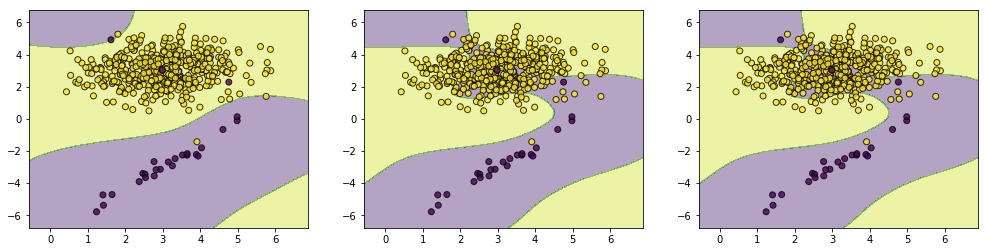

In [4]:
plt.figure(figsize = (17,4))
plt.subplot(1,3,1)
plot_decision_function(X=X,y=y,clf=svc_with_balanced_weight,plt=plt)
plt.subplot(1,3,2)
plot_decision_function(X=X,y=y,clf=svc_with_userdefine_weight,plt=plt)
plt.subplot(1,3,3)
plot_decision_function(X=X,y=y,clf=svc_with_sample_weight,plt=plt)

假设不平衡比例$IR=\frac{N_-}{N_+}$，上面`class_weight='balanced'`等价于如下的代价矩阵：  

|     | 预测正类  |预测负类  |
|  :-:   | :-:  | :-:  |
| 真实正类  | 0 |IR |
| 真实负类  | 1 |0 |  

对于`class_weight={0:100,1:1}`则等价于：  

|     | 预测正类  |预测负类  |
|  :-:   | :-:  | :-:  |
| 真实正类  | 0 |100 |
| 真实负类  | 1 |0 |  

### 代价敏感学习对损失函数的影响

我们对`class_weight`的赋值等价于对代价矩阵调整，但sklearn还支持很细粒度的调整，即对于样本也可以做权重调整，我们可以将代价敏感学习对损失函数的调整做如一下数学表达，  

原始的损失函数可以表达为：  

$$
L(x,y,w)=\sum_{i=1}^N l(x_i,y_i,w)
$$  

即损失函数可以拆解为$N$个样本的损失之和，做权重调整后，新的损失函数可以表达为：  

$$
L(x,y,w)=\sum_{i=1}^N cw(c(i))\cdot sw(i)\cdot l(x_i,y_i,w)
$$  

这里$c(i)$表示样本$i$所属的类别，$cw(c)$表示类别$c$的类别权重，$sw(i)$表示样本$i$的样本权重


比如以上面的SVM为例，其：  
$$
l(x_i,y_i,w)=\frac{1}{2N}w^Tw+C\varepsilon_i\\
y_i(w^T\phi(x_i)+b)\geq 1-\varepsilon_i,\varepsilon_i\geq0
$$

### 学习的方式

由上面的例子，对于不平衡的情况`balanced`是个不错的选择，但是如果过于关注少数类（第3,4种情况）也不好，所以代价敏感学习重点就在于如何学习一个比较好的代价矩阵以即样本权重向量，一般来说有以下几种方式：  

#### 1.经验学习

经验学习仅利用类别不平衡比例$IR$，即sklearn中`class_weight='balanced'`的情况，对于类别数>2的情况，可以固定数量最多的类的惩罚为$M$，其它少数类依次与其做对比，按样本不平衡比率调整即可$IR\times M$

#### 2.模糊加权  
模糊加权相当于在考虑`class_weight`的情况下，进一步考虑`sample_weight`的分布，因为所有少数类样本未必都是优质的，它有可能会是噪声或者离群点，如果模型过渡关注于这样的点反而有害，比如上面的第3，4种情况，我们可以通过设置样本权重的方式消除这种影响，比如下面，去掉异常点的影响：  

In [5]:
imbu=ImbLearnUtils()
imbu.fit(X,y)

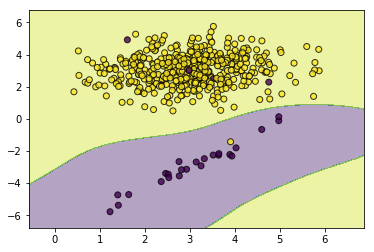

In [6]:
#将异常点的权重设置为0，其余为1
sample_weights=1-imbu.abnormal_marks
svc_without_abnormal_points=SVC(class_weight={0:100,1:1})
svc_without_abnormal_points.fit(X,y,sample_weight=sample_weights)
plot_decision_function(X=X,y=y,clf=svc_without_abnormal_points,plt=plt)

上面剔除异常点是使用的k近邻的方式，当然还可以选择其它的方式，比如基于类内质心距离的方式，它们本质上都是在降低异常点的权重，下面对其做一个简单介绍并实现
##### 模糊加权：基于类内质心距离的方法
我们做个假设：同一类别的数据服从高斯分布，也就是说每一个类别的大部分样本均聚集在该类中心附近，而**噪声**样本和**离群**样本恰好具有远离同类中心的特性，所以对于每个样本，若它离同类中心越近，则应该具有越高的重要度。我们假设每个点离其类中心的距离为$d_i$，同类中最大距离表示为$d_{c(i)}^{max}$，我们可以通过如下公式表示样本重要度：  

$$
weight_i=1-\frac{d_i}{d_{c(i)}^{max}},i=1,2,...,N
$$

In [7]:
import numpy as np
# 统计正负类的下标
pos_index=np.where(y==0)
neg_index=np.where(y==1)
# 计算中心点聚类
pos_mean=np.mean(X[pos_index],axis=0)
neg_mean=np.mean(X[neg_index],axis=0)
# 计算各个点距离同类中心点的距离
pos_max_distance=0
neg_max_distance=0
distances=[]
for index in range(0,len(y)):
    #正类
    if index in pos_index[0]:
        # 计算欧式距离
        distance=np.dot(X[index,:]-pos_mean,X[index,:]-pos_mean)
        if distance>pos_max_distance:
            pos_max_distance=distance
    else:
        distance=np.dot(X[index,:]-neg_mean,X[index,:]-neg_mean)
        if distance>neg_max_distance:
            neg_max_distance=distance
    distances.append(distance)
    
#更新重要度
weights=[]
for index in range(0,len(y)):
    if index in pos_index[0]:
        weight=1-distances[index]/pos_max_distance
    else:
        weight=1-distances[index]/neg_max_distance
    weights.append(weight)

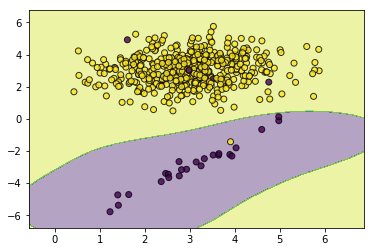

In [8]:
svc_with_l2_importance=SVC()
svc_with_l2_importance.fit(X,y,sample_weight=weights)
plot_decision_function(X=X,y=y,clf=svc_with_l2_importance,plt=plt)

#### 3.自适应加权

自适应加权法主要利用boosting集成学习的方式来求解一个较优的`weights`，在boosting过程的每一轮迭代中，根据前一轮的反馈结果动态调整`weights`，从而保证其逐步逼近全局最优，比较有代表性的算法有AdaCost, CSB1, CSB2, RareBoost等，这里接下来介绍比较有代表性的AdaCost算法：它在AdaBoost算法的基础上做了一些调整，将代价敏感的权重并入到每一轮的样本权重更新中

### 代价敏感学习与样本采样的关系

### 软件包补充
另外，还有一些不错的代价敏感学习包，比如：  

（1）`CostSensitiveClassification`包，通过`pip install costcla`安装即可，更多内容请看https://github.com/albahnsen/CostSensitiveClassification  

（2）`AdaCost`包：https://core.ac.uk/display/20995675